In [456]:
%matplotlib inline
%load_ext cython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from plotting_utils import label_sample, figure_path, cpm_total
import pandas as pd
import glob
import re
import os
from multiprocessing import Pool
import seaborn as sns
from matplotlib import rcParams
from sequencing_tools.viz_tools import color_encoder, okabeito_palette, simpsons_palette
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from Bio import SeqUtils

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
cpm_base = cpm_total()

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [457]:
%%cython
from collections import Counter, defaultdict
from operator import itemgetter
import re
from xopen import xopen

sc_re = re.compile('([0-9]+)S')
cdef soft_clip_base(cigar):
    s = sc_re.findall(cigar)
    s = map(int, s)
    return sum(s)

cpdef get_start(sample_folder):
    cdef:
        str line
        str chrom, start, end, strand, cigar
        list fields
        int sstart, send
    
    tRNA_regex = re.compile('^TR[A-Z]-|^MT')
    end_loc_counter = defaultdict(Counter)
    bed_file = sample_folder + '/count_temp/small_RNA.bed.gz'
    with xopen(bed_file) as bed:
        for line in bed:
            fields = line.strip().split('\t')
            chrom, start, end, strand, cigar = itemgetter(0,1,2,5, 6)(fields)
            sstart, send = int(start), int(end)
            
            is_tRNA = tRNA_regex.search(chrom)
            is_sense = strand == "+"
            good_alignment = soft_clip_base(cigar) < 10 
            not_fulllength = (send - sstart) < 50
            if is_tRNA and is_sense and good_alignment and not_fulllength:
                end_loc_counter[long(start)][long(end)] += 1
    return end_loc_counter

In [458]:
sample_folders = glob.glob('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/*001')
sample_folders = filter(lambda x: re.search('^MP|^PP|^[Qq][cC][fF][0-9]+|[qQ][cC][fF]_[pP]hos|[DE][ED]|Exo|[fF]rag|GC', os.path.basename(x)), 
                     sample_folders) 
sample_folders = list(sample_folders)

In [469]:
df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/tsRNA.feather') \
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(is_mt = lambda d: np.where(d.tRNA.str.startswith('MT'),'MT-',''))\
    .groupby(['anticodon','prep','samplename','frag_type','aa','is_mt'], as_index=False) \
    .agg({'frag_count':'sum'}) \
    .assign(frag_fraction = lambda d: 100*d.groupby(['samplename','prep','aa','anticodon','is_mt']).frag_count.transform(lambda x: x/x.sum()))\
    .assign(cpm = lambda d: d.groupby(['samplename','prep']).frag_count.transform(lambda x: 1e6*x/x.sum()))\
    .query('frag_type != "Others"')  \
    .assign(anticodon = lambda d: d.is_mt + d.aa +'-'+ d.anticodon) \
    .sort_values(['is_mt','aa']) \
    .assign(frag_type = lambda d: d.frag_type.str.replace('half','tRNA-half'))
df.head()

,anticodon,prep,samplename,frag_type,aa,is_mt,frag_count,frag_fraction,cpm
903,Ala-AGC,Crude,MPCEV_R1_001,3' tRNA-half,Ala,,518896,81.020406,23185.864173
904,Ala-AGC,Crude,MPCEV_R1_001,5' tRNA-half,Ala,,30,0.004684,1.340492
905,Ala-AGC,Crude,MPCEV_R1_001,Full-length,Ala,,82423,12.869525,3682.912342
907,Ala-AGC,Crude,MPCEV_R1_001,tRF-3,Ala,,2181,0.340541,97.453767
908,Ala-AGC,Crude (MNase),PPCEV_R1_001,3' tRNA-half,Ala,,87218,78.166338,17924.326862


In [470]:
df.prep.unique()

array(['Crude', 'Crude (MNase)', 'DNase I', 'DNase I + Exo I',
       "DNase I - 3'P", 'EV', 'EV (MNase)', 'Fragmented', 'HEK293',
       'High salt (450mM)', 'NaOH', 'RNP', 'RNP (MNase)', 'Untreated'],
      dtype=object)

In [484]:
prep = ['DNase I', "DNase I - 3'P"]#,'HEK293']#, 'MNase RNP','MNase EV']#,"HEK293"]
tsRNA = ['Full-length', "5' tRNA-half","3' tRNA-half", "tRF-3"]#, "5' tsRNA"]


In [500]:
def plot_fragments(df, y = 'frag_fraction', 
                   figurename='', 
                   plot_mt = 'no', 
                   prep = prep, 
                   dodge = True,
                  cpm_norm = 'total'):
    ylab = '% Reads' if y == 'frag_fraction' else 'CPM'
    mt = df.anticodon.str.contains('MT')
    if plot_mt == 'no':
        df = df[~mt]
    elif plot_mt == 'only':
        df = df[mt]
    elif plot_mt == 'yes':
        pass
    
    if cpm_norm != 'total':        
        df = df \
            .assign(cpm = lambda d: d\
                                .groupby(['samplename','prep','frag_type'])\
                                .cpm.transform(lambda x: 1e6*x/x.sum()))

    
    anticodon = df.anticodon.unique().tolist()
    p = sns.FacetGrid(data = df.pipe(lambda d: d[d.prep.isin(prep)]), 
                col = 'frag_type', 
                col_wrap=1, 
                col_order = tsRNA,
                aspect=5,
                sharey=False)
    p.map(sns.stripplot,
          'anticodon',
          y,
          'prep',
          alpha=0.6,
          jitter = 0,
          hue_order = prep,
          order = anticodon,
          dodge=dodge,
          palette = ['#28378c','#ff3511','#85a9e2','#f7cd62','red'])
    for ax in p.fig.axes:
        ax.set_xticklabels(ax.get_xticklabels(),
                      rotation=70,
                      ha = 'right',
                      rotation_mode='anchor')
        for xt in ax.get_xticklabels():
            if xt.get_text().startswith('MT'):
                xt.set_color('purple')
        ax.text(0, ax.get_ylim()[1],ax.get_title().split('=')[1], size=15)
    p.set_titles('')
    p.add_legend(fontsize=15, bbox_to_anchor=(0.2,0.95))
    p.set_axis_labels('Anticodon', ylab)
    for ax in p.fig.axes:
        ax.get_yaxis().set_label_coords(-0.06,0.5)
    p.savefig(figurename, bbox_inches='tight', transparent=True)
    return p

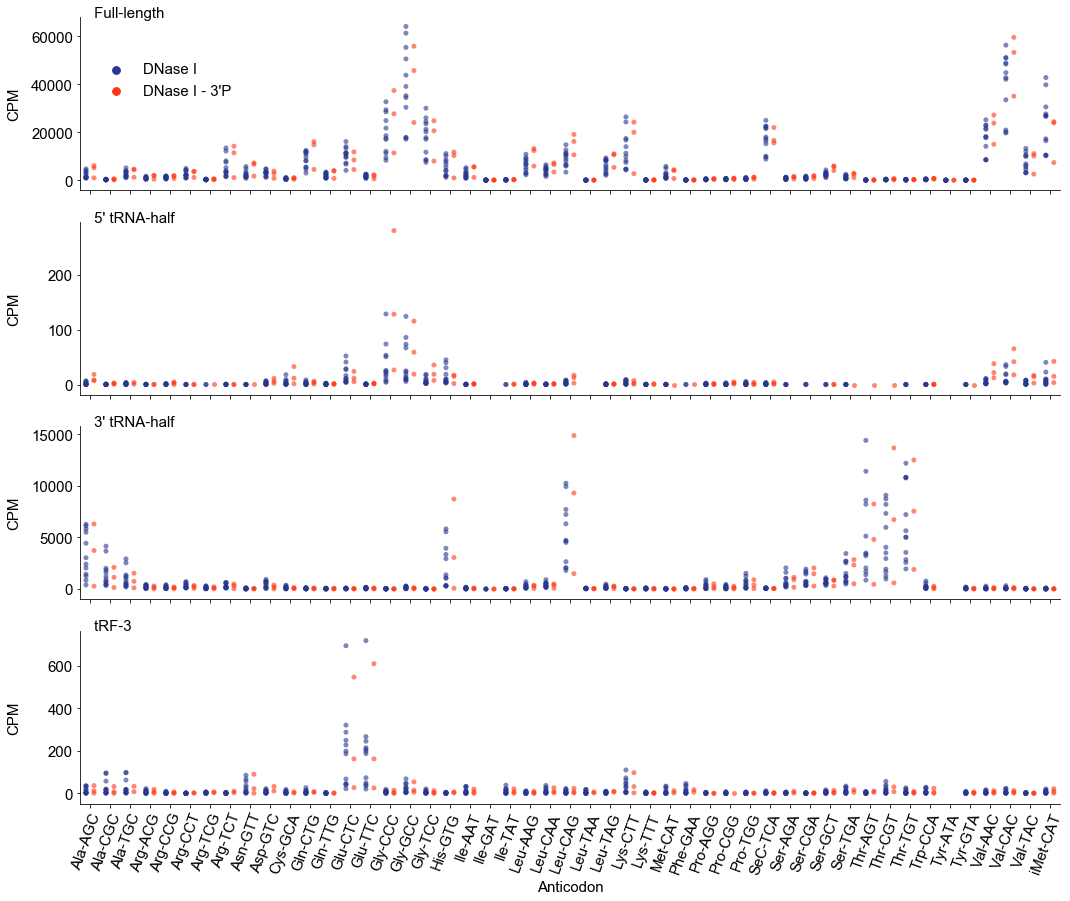

In [501]:
figurename = figure_path + '/tRNA_fragment_cpm.pdf'
p = plot_fragments(df , y = 'cpm', plot_mt = 'no', figurename = figurename)

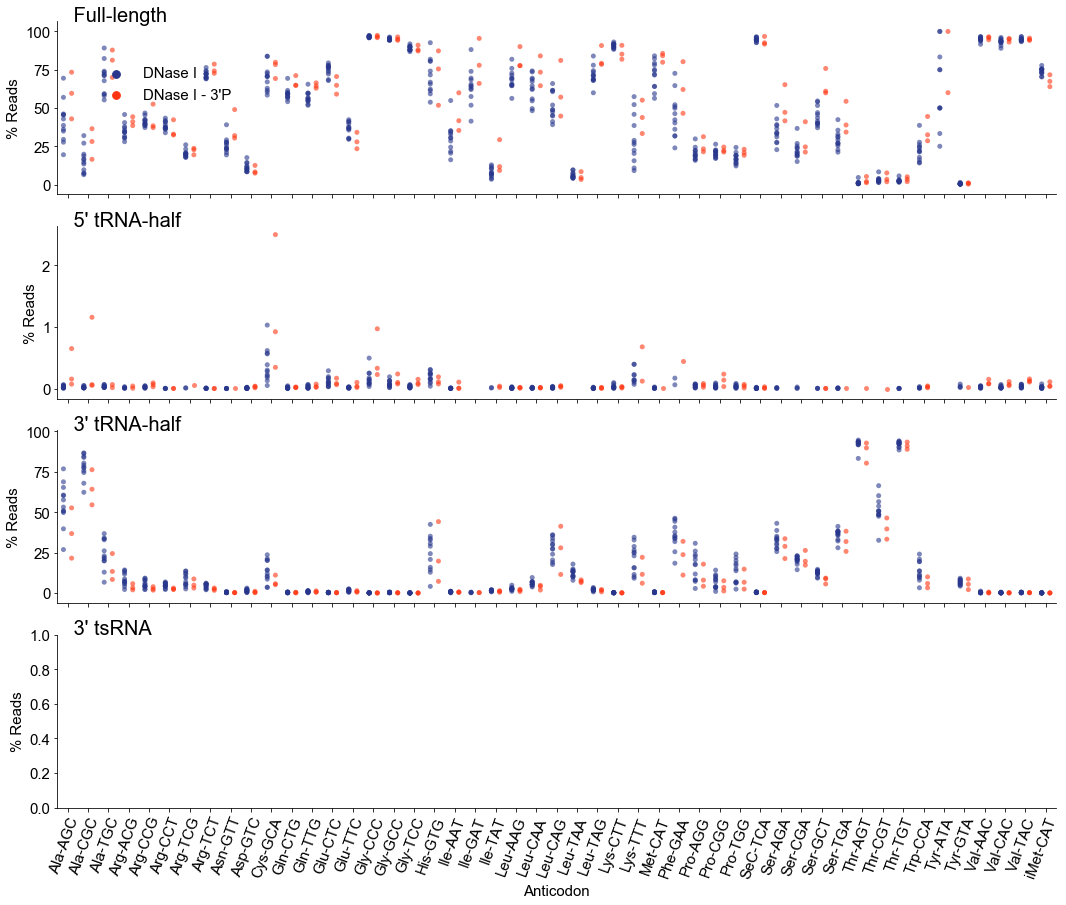

In [474]:
figurename = figure_path + '/tRNA_fragment_percentage.pdf'
plot_fragments(df , y = 'frag_fraction', figurename = figurename, plot_mt='no')

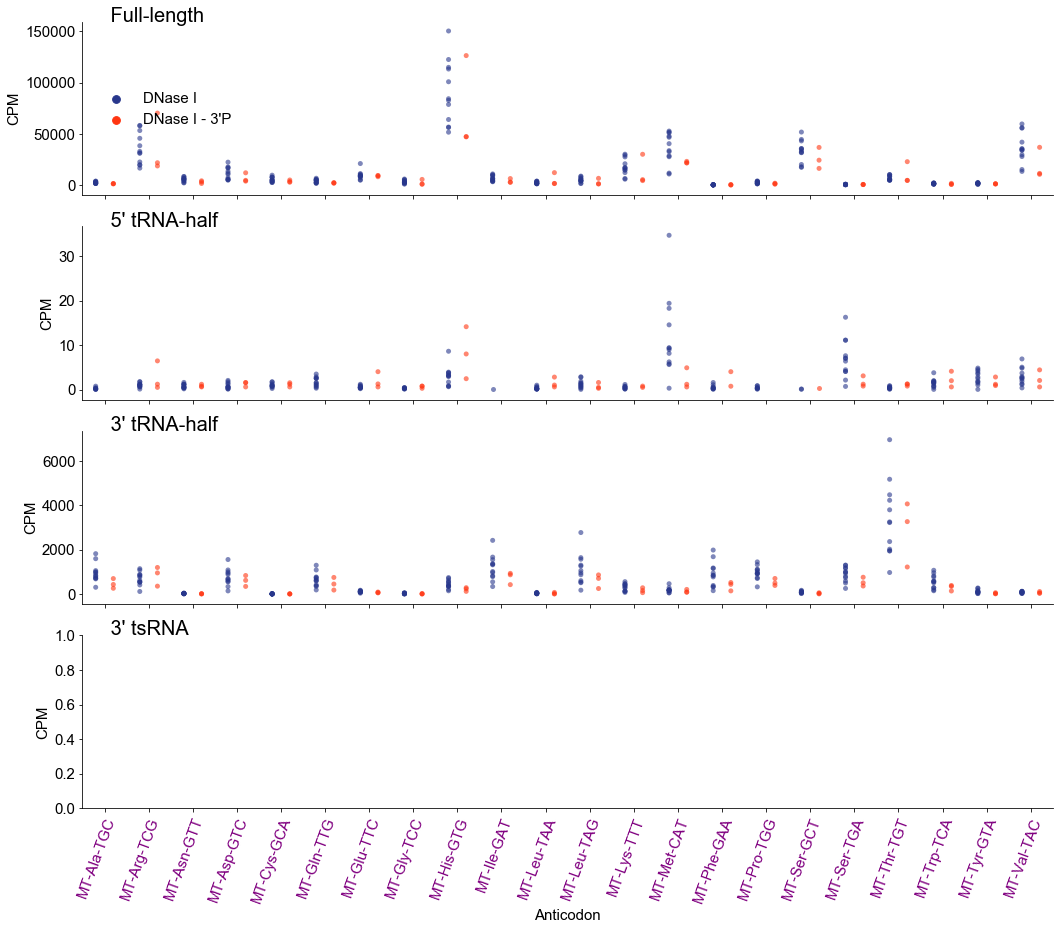

In [475]:
figurename = figure_path + '/tRNA_mt_fragment_cpm.pdf'
p = plot_fragments(df , y = 'cpm', plot_mt = 'only', figurename = figurename)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


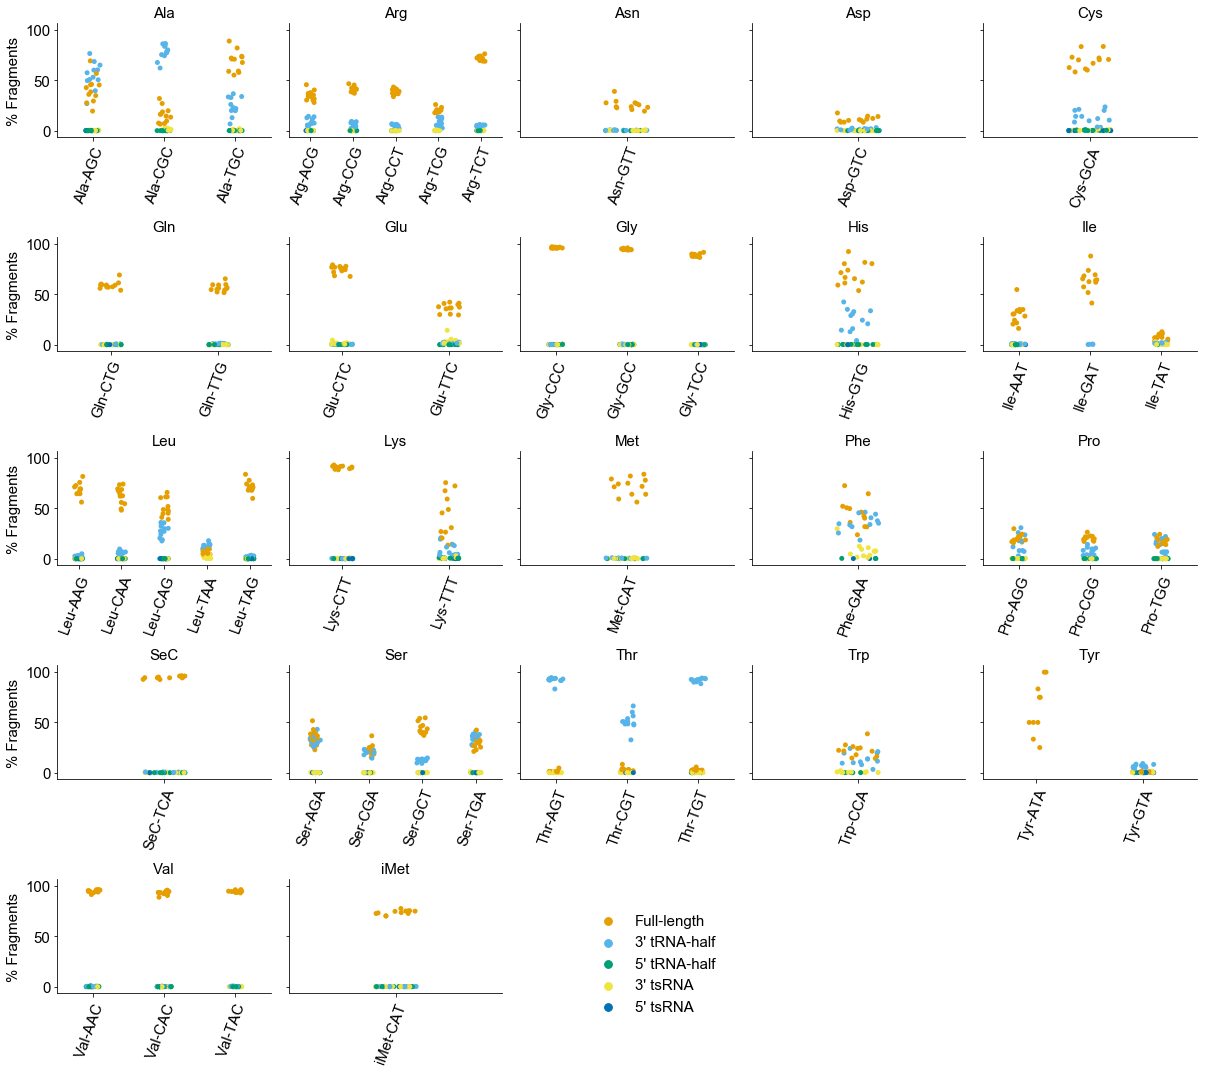

In [240]:
p = sns.FacetGrid(data = df \
        .query('prep == "DNase I"') \
        .pipe(lambda d: d[~d.anticodon.str.contains('MT')]),
    col = 'aa',
    aspect = 1,
    col_wrap = 5,
    sharex=False)
p.map(sns.stripplot,
    'anticodon',
    'frag_fraction',        
    'frag_type',
     hue_order = tsRNA,
     palette = okabeito_palette())
for ax in p.fig.axes:
    xts = ax.set_xticklabels(ax.get_xticklabels(),
                      rotation=70,
                      ha = 'right',
                      rotation_mode='anchor')
p.add_legend(frameon=False,fontsize=15, bbox_to_anchor = (0.6,0.1))
p.set_axis_labels('','% Fragments')
p.set_titles('{col_name}')
figurename = figure_path + '/fragment_percentage.pdf'
p.fig.tight_layout()
p.savefig(figurename, bbox_inches='tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


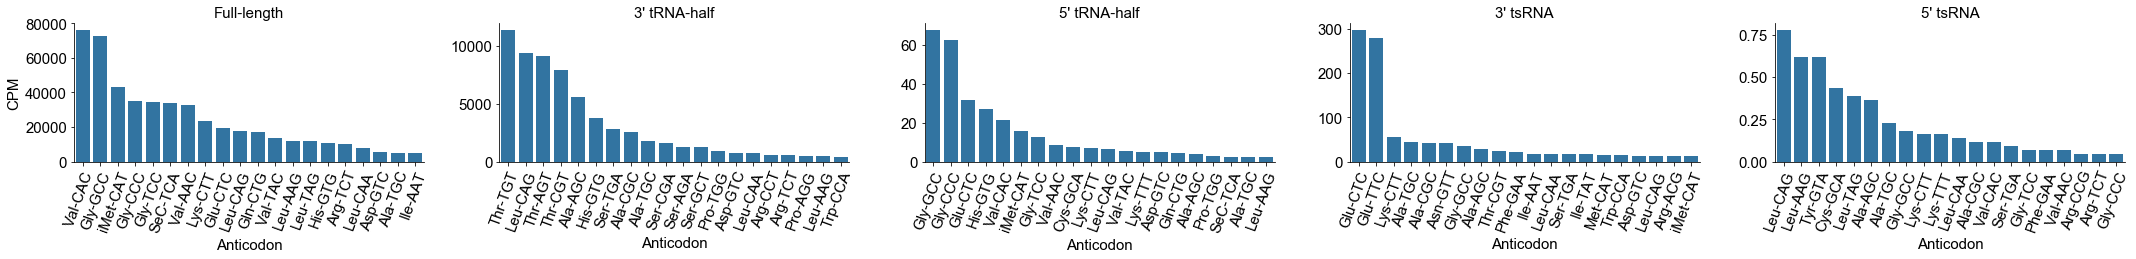

In [243]:
p = sns.FacetGrid(data = df\
        .query('prep == "DNase I"')\
        .pipe(lambda d: d[~d.anticodon.str.contains('MT')])\
        .groupby(['anticodon','frag_type'], as_index=False)\
        .agg({'frag_count':'sum'}) \
        .assign(cpm = lambda d: d.frag_count.transform(lambda x: 1e6 * x/cpm_base.prep_cpm['DNase I'])) \
        .query('cpm >0') \
        .groupby('frag_type', as_index=False)\
        .apply(lambda d: d.nlargest(20, 'cpm')),
    col = 'frag_type',
    sharex=False,
    sharey=False,
    col_order = tsRNA,
    aspect=2,
    size=3)
p.map(sns.barplot,
    'anticodon',
    'cpm')
p.set_titles('{col_name}')
for ax in p.fig.axes:
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation=70,
                       rotation_mode='anchor',
                      ha='right')
p.set_axis_labels('Anticodon','CPM')
p.savefig(figure_path + '/tsRNA_bar.pdf', bbox_inches='tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


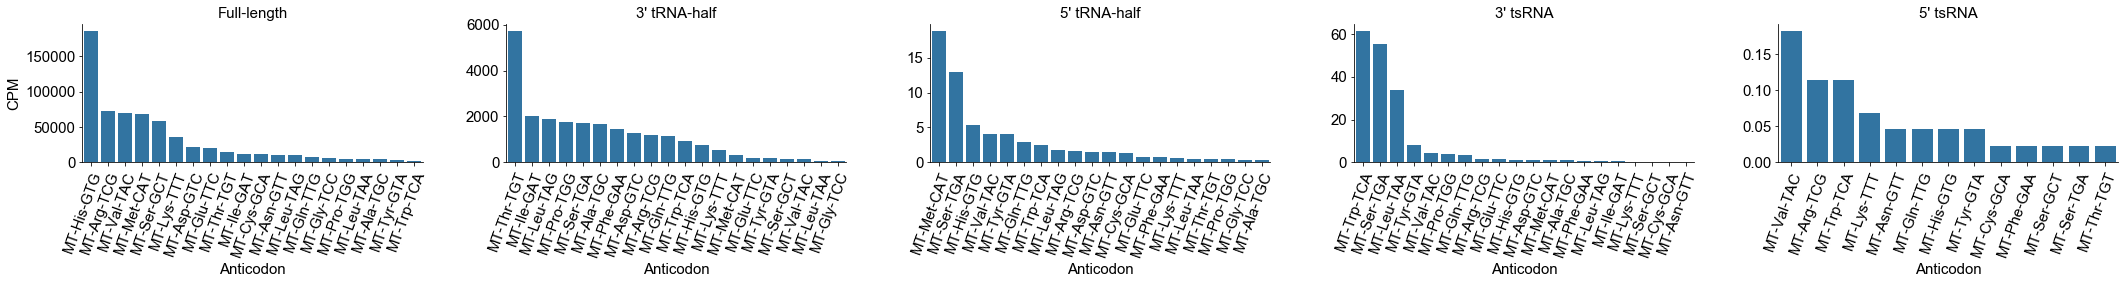

In [244]:
p = sns.FacetGrid(data = df\
        .query('prep == "DNase I"')\
        .pipe(lambda d: d[d.anticodon.str.contains('MT')])\
        .groupby(['anticodon','frag_type'], as_index=False)\
        .agg({'frag_count':'sum'}) \
        .assign(cpm = lambda d: d.frag_count.transform(lambda x: 1e6 * x/cpm_base.prep_cpm['DNase I'])) \
        .query('cpm >0') \
        .groupby('frag_type', as_index=False)\
        .apply(lambda d: d.nlargest(20, 'cpm')),
    col = 'frag_type',
    sharex=False,
    sharey=False,
    col_order = tsRNA,
    aspect=2,
    size=3)
p.map(sns.barplot,
    'anticodon',
    'cpm')
p.set_titles('{col_name}')
for ax in p.fig.axes:
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation=70,
                       rotation_mode='anchor',
                      ha='right')
p.set_axis_labels('Anticodon','CPM')
p.savefig(figure_path + '/tsRNA_mt_bar.pdf', bbox_inches='tight')

In [385]:
ce = color_encoder()
ce.fit(['Mt-tRNA','tRNA'],['#0e238c','#edc03b'])
comp_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/tsRNA.feather')  \
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(is_mt = lambda d: np.where(d.tRNA.str.startswith('MT'),'Mt-tRNA','tRNA')) \
    .groupby(['prep','is_mt','anticodon','tRNA','aa'], as_index=False)\
    .agg({'frag_count':'sum'})\
    .assign(cpm = lambda d: d.groupby('prep').frag_count.transform(lambda x: 1e6*x/x.sum()))\
    .assign(log_cpm = lambda d: d.cpm.transform(np.log10))\
    .assign(color = lambda d: ce.transform(d.is_mt)) \
    .pipe(pd.pivot_table,
         index = ['is_mt','anticodon','tRNA','aa','color'],
         columns = 'prep',
         values = 'log_cpm',
         fill_value = 0) \
    .reset_index() 
comp_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


prep,is_mt,anticodon,tRNA,aa,color,DNase I,DNase I + Exo I,DNase I - 3'P,EV,Fragmented,HEK293,High salt (450mM),MNase EV,MNase EV+RNP,MNase RNP,NaOH,RNP,RNP+EV,Untreated
0,Mt-tRNA,CAT,MT-TM,Met,#edc03b,4.577166,4.768024,4.380853,1.712091,4.533812,4.029759,4.888632,2.166541,2.237491,2.245541,4.716419,2.325678,1.768221,4.344440
1,Mt-tRNA,GAA,MT-TF,Phe,#edc03b,3.107003,3.334009,2.944145,0.369669,3.184606,3.952364,3.463644,0.303218,0.914239,1.114060,3.469451,1.522904,0.719003,2.811642
2,Mt-tRNA,GAT,MT-TI,Ile,#edc03b,4.315696,4.400316,4.019304,1.483612,4.109690,4.848313,4.697654,1.808368,1.841096,2.009325,4.510844,2.119501,1.692130,4.103327
3,Mt-tRNA,GCA,MT-TC,Cys,#edc03b,3.894855,3.922010,3.658879,1.515797,3.748386,3.916693,3.892175,1.750376,1.893104,1.937969,4.019123,2.079207,1.381760,3.964680
4,Mt-tRNA,GCT,MT-TS2,Ser,#edc03b,4.494696,4.677543,4.448755,1.448850,4.482089,3.447625,4.304841,1.808368,1.759337,1.960633,4.413709,2.311779,1.599816,4.194542


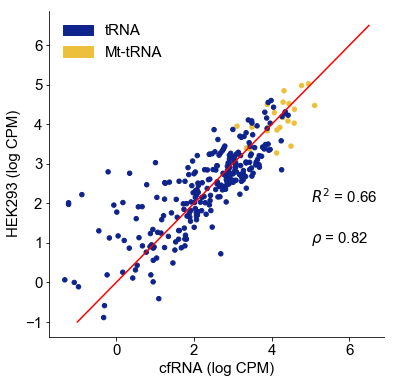

In [389]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
x = 'DNase I'
y = 'HEK293'
comp_df.plot.scatter(x = x, 
            y = y,
            color = comp_df.color.tolist(),
            ax = ax)
ax.plot([-1,6.5],[-1,6.5], color = 'red')
ce.show_legend(ax = ax, fontsize=15,
              frameon=False)
r2 = r2_score(comp_df[x], comp_df[y])
r, pval = pearsonr(comp_df[x], comp_df[y])
ax.text(5,1, r'$\rho$ = %.2f' %(r), fontsize=15)
ax.text(5,2, r'$R^2$ = %.2f' %(r2), fontsize=15)
ax.set_xlabel('cfRNA (log CPM)')
ax.set_ylabel('HEK293 (log CPM)')
sns.despine()
fig.savefig(figure_path + '/tsRNA_cell.pdf', bbox_inches='tight')

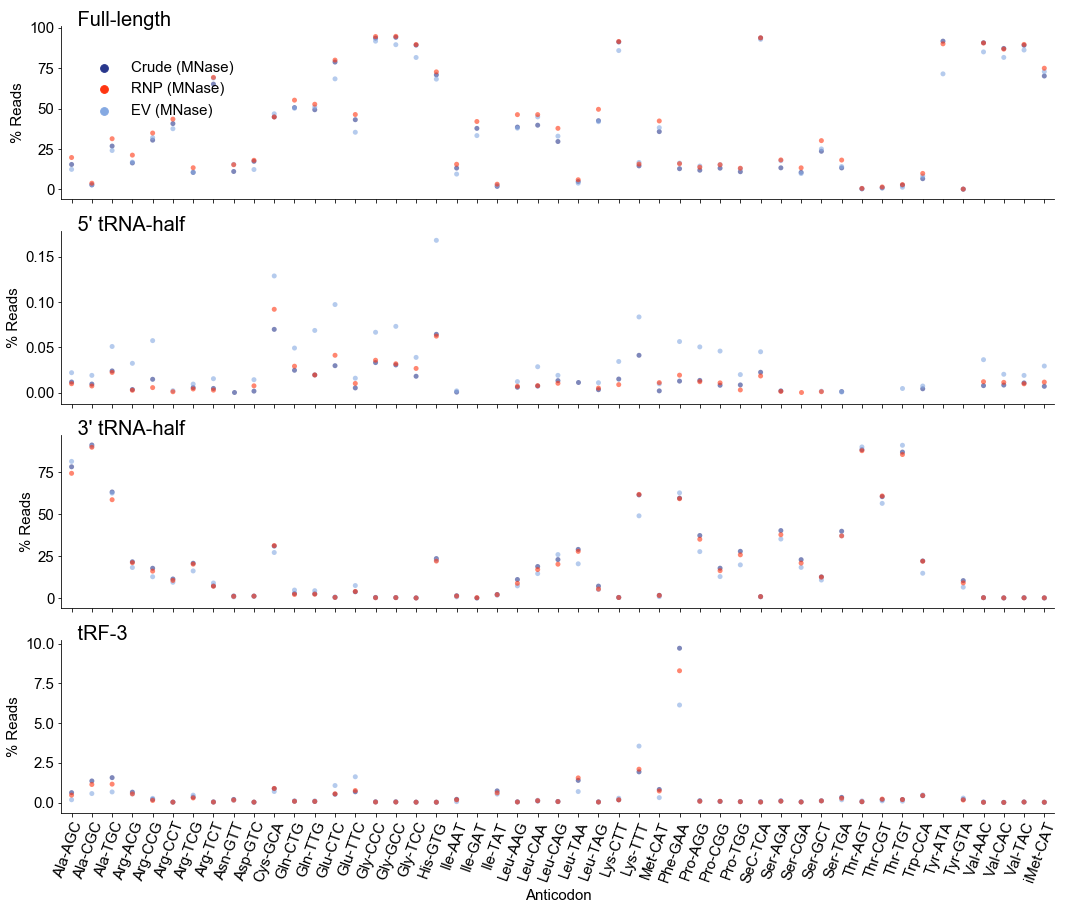

In [487]:
figurename = figure_path + '/EV_tRNA_fragment_cpm.pdf'
p = plot_fragments(df , y = 'frag_fraction', plot_mt = 'no', 
                   figurename = figurename, 
                   prep = ['Crude (MNase)','RNP (MNase)','EV (MNase)'],
                  dodge=False, cpm_norm='tRNA')